<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TXT_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Bidirectional, LSTM, GRU, Dropout, GlobalAveragePooling1D

## Data gathering

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(ds_train, ds_val), ds_info = tfds.load("imdb_reviews", split=["train", "test"], shuffle_files=True, as_supervised=True, with_info=True)
ds_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

**Inspect samples from datasets**

Binary classification:
- Negative: 0
- Positive: 1

In [3]:
sample = next(iter(ds_train))
print("Review:", sample[0].numpy())
print("Label:", sample[1].numpy())

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


In [4]:
train_data, train_labels = [], []
for review, label in ds_train:
  train_data.append(str(review.numpy()))
  train_labels.append(label.numpy())

val_data, val_labels = [], []
for review, label in ds_val:
  val_data.append(str(review.numpy()))
  val_labels.append(label.numpy())

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))

Number of training samples: 25000
Number of validation samples: 25000


Brief analysis to decide proper hparams.

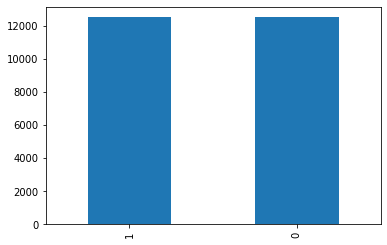

In [5]:
pd.Series(train_labels).value_counts().plot(kind="bar");

In [6]:
pd.Series(train_data).apply(lambda x : len(x.split())).describe()

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
dtype: float64

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024
VOCAB_SIZE = 1000
EMBED_DIM = 64
MAX_SEQ_LEN = 256

## Featurizing

**Tokenizing and padding sequences**

The average number of tokens persample isi 233. Hence, we choose `MAX_SEQ_LEN = 256`.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data)

In [9]:
def create_tfds(tokenizer, X, y, padding=False):
  if padding:
    X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_SEQ_LEN, padding="post")
  return tf.data.Dataset.from_tensor_slices((X, y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

ds_train = create_tfds(tokenizer, train_data, train_labels, padding=True)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=True)

## Model Architecture

In [10]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, input_length=MAX_SEQ_LEN, output_dim=EMBED_DIM))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 64)           64000     
_________________________________________________________________
dropout (Dropout)            (None, 256, 64)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 64,065
Trainable params: 64,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [12]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[callbacks]);

Epoch 1/20
391/391 [==============================] - 3s 8ms/step - loss: 0.6581 - acc: 0.6933 - val_loss: 0.6108 - val_acc: 0.7288
Epoch 2/20
391/391 [==============================] - 3s 7ms/step - loss: 0.5544 - acc: 0.7749 - val_loss: 0.5026 - val_acc: 0.7940
Epoch 3/20
391/391 [==============================] - 3s 7ms/step - loss: 0.4596 - acc: 0.8178 - val_loss: 0.4247 - val_acc: 0.8248
Epoch 4/20
391/391 [==============================] - 3s 7ms/step - loss: 0.3999 - acc: 0.8383 - val_loss: 0.3800 - val_acc: 0.8427
Epoch 5/20
391/391 [==============================] - 3s 7ms/step - loss: 0.3678 - acc: 0.8478 - val_loss: 0.3582 - val_acc: 0.8497
Epoch 6/20
391/391 [==============================] - 3s 8ms/step - loss: 0.3496 - acc: 0.8531 - val_loss: 0.3446 - val_acc: 0.8543
Epoch 7/20
391/391 [==============================] - 3s 8ms/step - loss: 0.3395 - acc: 0.8574 - val_loss: 0.3370 - val_acc: 0.8576
Epoch 8/20
391/391 [==============================] - 3s 8ms/step - loss: 0.

### Transfer learning w. pretrained embedding

In [13]:
ds_train = create_tfds(tokenizer, train_data, train_labels, padding=False)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=False)

In [14]:
embedding_url = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"

model = Sequential()
model.add(hub.KerasLayer(embedding_url, input_shape=(), dtype=tf.string, trainable=True))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 48,190,651
Trainable params: 48,190,651
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [16]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[callbacks]);

Epoch 1/20
391/391 [==============================] - 8s 20ms/step - loss: 0.5048 - acc: 0.7598 - val_loss: 0.3695 - val_acc: 0.8557
Epoch 2/20
391/391 [==============================] - 8s 20ms/step - loss: 0.3142 - acc: 0.8716 - val_loss: 0.2921 - val_acc: 0.8799
Epoch 3/20
391/391 [==============================] - 8s 19ms/step - loss: 0.2512 - acc: 0.8997 - val_loss: 0.2695 - val_acc: 0.8896
Epoch 4/20
391/391 [==============================] - 8s 21ms/step - loss: 0.2193 - acc: 0.9140 - val_loss: 0.2620 - val_acc: 0.8916
Epoch 5/20
391/391 [==============================] - 8s 22ms/step - loss: 0.1955 - acc: 0.9262 - val_loss: 0.2594 - val_acc: 0.8928
Epoch 6/20
391/391 [==============================] - 8s 21ms/step - loss: 0.1799 - acc: 0.9326 - val_loss: 0.2665 - val_acc: 0.8897
Epoch 7/20
391/391 [==============================] - 8s 22ms/step - loss: 0.1653 - acc: 0.9390 - val_loss: 0.2655 - val_acc: 0.8920
Epoch 8/20
391/391 [==============================] - 8s 21ms/step - 

In [18]:
model.evaluate(ds_val)

391/391 [==============================] - 3s 7ms/step - loss: 0.2748 - acc: 0.8903


[0.2747659683227539, 0.89028000831604]